<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [5]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [12]:
def csr_matrix_parameters(X):
    """Calculating parameters for creating a sparse matrix"""
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for session in X:
        for site in session:
            index = vocabulary.setdefault(site, site)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return [data, indices, indptr]

In [13]:
data, indices, indptr = csr_matrix_parameters(train_test_df_sites.values)
train_test_sparse = csr_matrix((data, indices, indptr))[:, 1:]
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df.target.values

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [14]:
print('X_train_sparse: {} X_test_sparse: {}'.format(X_train_sparse.shape, 
                                                    X_test_sparse.shape))

X_train_sparse: (253561, 48371) X_test_sparse: (82797, 48371)


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [15]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [16]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [17]:
sgd_logit = SGDClassifier(loss='log', random_state=17, 
                          n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log', n_jobs=-1, random_state=17)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [18]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [19]:
valid_roc_auc = round(roc_auc_score(y_valid, logit_valid_pred_proba), 3)
print('Baseline valid ROC AUC score: {}'.format(valid_roc_auc))

Baseline valid ROC AUC score: 0.934


**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [20]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

CPU times: user 803 ms, sys: 41.9 ms, total: 845 ms
Wall time: 607 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [21]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [22]:
write_to_submission_file(logit_test_pred_proba, 'result.csv')

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.

## Улучшение бейзлайна

### 1. Создание новых признаков

In [23]:
def feature_engineering(X_data):
    """Creating new features"""
    
    sites = X_data[['site{}'.format(i) for i in range(1, 11)]].fillna(0).astype('int').values
    times = X_data[['time{}'.format(i) for i in range(1, 11)]]
    new_features = pd.DataFrame()
    
    for i in range(1, 10):
        new_features['time_diff{}'.format(i)] = ( 
            (pd.to_datetime(times['time{}'.format(i + 1)]) \
            - pd.to_datetime(times['time{}'.format(i)]))).dt.total_seconds().fillna(0)
        
    new_features['session_timespan'] = np.sum(new_features, axis=1)
    new_features['#unique_sites'] = [len(np.unique(session[session != 0])) 
                                     for session in sites]
    new_features['start_hour'] = pd.to_datetime(times['time1']).dt.hour
    new_features['day_of_week'] = pd.to_datetime(times['time1']).dt.weekday
    
    return new_features

new_train_features = feature_engineering(train_df)
new_test_features = feature_engineering(test_df)

In [24]:
new_train_features.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week
session_id,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10,3
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,7,11,5
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,4,16,0
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,1,10,4
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,4,10,4


### 2. Масштабирование вещественных признаков

In [25]:
# Separating numerical features from categorical features
new_train_num = new_train_features.loc[:, :'#unique_sites']
new_test_num = new_test_features.loc[:, :'#unique_sites']
new_train_cat = new_train_features.loc[:, 'start_hour':]
new_test_cat = new_test_features.loc[:, 'start_hour':]

# Scaling the numerical features
scaler = StandardScaler()
new_train_num[new_train_num.columns] = scaler.fit_transform(new_train_num)
new_test_num[new_test_num.columns] = scaler.fit_transform(new_test_num)

In [26]:
new_train_num.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites
session_id,,,,,,,,,,,
1,-0.191229,-0.180434,-0.186631,-0.193139,-0.192809,-0.193165,-0.192025,-0.190596,-0.190791,-0.468233,-1.858194
2,-0.191229,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.192025,0.140975,-0.175945,-0.380330,0.545477
3,-0.181131,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.177680,-0.176180,-0.161099,-0.444566,-0.656359
4,0.111727,0.103540,0.137505,0.189184,0.202862,0.221062,0.238309,0.241888,0.254585,0.444604,-1.858194
5,1.192272,-0.180434,-0.175826,-0.193139,0.281996,-0.193165,-0.192025,0.775285,-0.116561,0.363463,-0.656359


### 3. Кодирование категориальных признаков

In [27]:
# Encoding
encoder = OneHotEncoder()
new_train_cat_ohe = encoder.fit_transform(new_train_cat)
new_test_cat_ohe = encoder.transform(new_test_cat)

In [28]:
# Creating Dataframes of the encoded categorical features
columns_start_hour = ['start_hour_{}'.format(i)  for i in encoder.categories_[0]]
columns_day_of_week = ['day_of_week_{}'.format(i) for i in encoder.categories_[1]]

new_train_cat_ohe_df = pd.DataFrame(new_train_cat_ohe.toarray(), 
                                    columns=columns_start_hour + columns_day_of_week, 
                                    index=range(1, new_train_cat_ohe.toarray().shape[0] + 1))
new_test_cat_ohe_df = pd.DataFrame(new_test_cat_ohe.toarray(), 
                                    columns=columns_start_hour + columns_day_of_week, 
                                   index=range(1, new_test_cat_ohe.toarray().shape[0] + 1))

In [29]:
new_train_cat_ohe_df.head()

,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,...,start_hour_21,start_hour_22,start_hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 4. Объединение признаков и разделение выборки на обучающую и тестовую

In [30]:
# Stacking the scaled features and the encoded features
new_train_features1 = pd.concat([new_train_num, 
                                 new_train_cat_ohe_df], 
                                axis=1)
new_test_features1 = pd.concat([new_test_num, 
                                new_test_cat_ohe_df], 
                               axis=1)

In [31]:
new_train_features1.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,...,start_hour_21,start_hour_22,start_hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1,-0.191229,-0.180434,-0.186631,-0.193139,-0.192809,-0.193165,-0.192025,-0.190596,-0.190791,-0.468233,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.191229,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.192025,0.140975,-0.175945,-0.380330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.181131,-0.170968,-0.186631,-0.193139,-0.192809,-0.179357,-0.177680,-0.176180,-0.161099,-0.444566,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.111727,0.103540,0.137505,0.189184,0.202862,0.221062,0.238309,0.241888,0.254585,0.444604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.192272,-0.180434,-0.175826,-0.193139,0.281996,-0.193165,-0.192025,0.775285,-0.116561,0.363463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
# Creating sparse matrices
new_train_features1_sparse = csr_matrix(new_train_features1)
new_test_features1_sparse = csr_matrix(new_test_features1)

# Splitting the new features for train and validation
ntf1_train = new_train_features1_sparse[:train_share, :]
ntf1_valid = new_train_features1_sparse[train_share:, :]

# Stacking the original data with the new features
X_train_nf1 = hstack((X_train, ntf1_train))
X_valid_nf1 = hstack((X_valid, ntf1_valid))
X_test_nf1 = hstack((X_test_sparse, new_test_features1_sparse))

### 5. Обучение модели и предсказание на новых признаках

In [33]:
# Type of cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

sgd_logit2 = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

#Cross-validation score
new_features1_cvs = cross_val_score(sgd_logit2, X_train_nf1, 
                                    y_train, cv=skf, 
                                    scoring='roc_auc')
print('SGDClassifier with new features cross_val_score:')
print('{}, {}\n'.format(new_features1_cvs, new_features1_cvs.mean()))

#Prediction
sgd_logit2.fit(X_train_nf1, y_train)
roc_auc_nf1 = roc_auc_score(y_valid, 
                            sgd_logit2.predict_proba(X_valid_nf1)[:, 1])
print('SGDClassifier with new features valid ROC AUC score: {}'.format(roc_auc_nf1))

SGDClassifier with new features cross_val_score:
[0.97360552 0.96955687 0.97744652], 0.9735363013710642

SGDClassifier with new features valid ROC AUC score: 0.9743038864141949


### 6. Подбор параметров модели

In [34]:
sgd_params = {'alpha': np.linspace(1e-5, 1e-1, 40)}
sgd_grid_searcher1 = GridSearchCV(sgd_logit2, sgd_params, 
                                  scoring='roc_auc', cv=skf,
                                  return_train_score=True,
                                  n_jobs=-1)
sgd_grid_searcher1.fit(X_train_nf1, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=SGDClassifier(loss='log', n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 2.57384615e-03, 5.13769231e-03, 7.70153846e-03,
       1.02653846e-02, 1.28292308e-02, 1.53930769e-02, 1.79569231e-02,
       2.05207692e-02, 2.30846154e-02, 2.56484615e-02, 2.82123077e-0...
       4.10315385e-02, 4.35953846e-02, 4.61592308e-02, 4.87230769e-02,
       5.12869231e-02, 5.38507692e-02, 5.64146154e-02, 5.89784615e-02,
       6.15423077e-02, 6.41061538e-02, 6.66700000e-02, 6.92338462e-02,
       7.17976923e-02, 7.43615385e-02, 7.69253846e-02, 7.94892308e-02,
       8.20530769e-02, 8.46169231e-02, 8.71807692e-02, 8.97446154e-02,
       9.23084615e-02, 9.48723077e-02, 9.74361538e-02, 1.00000000e-01])},
             return_train_score=True, scoring='roc_auc')

In [35]:
print('The best ROC AUC score: {}'.format(sgd_grid_searcher1.best_score_))
print('The best alpha: {}'.format(sgd_grid_searcher1.best_params_))

The best ROC AUC score: 0.983139100194374
The best alpha: {'alpha': 1e-05}


In [36]:
roc_auc_best_alpha = roc_auc_score(y_valid, 
                                   sgd_grid_searcher1.best_estimator_.predict_proba(X_valid_nf1)[:, 1])
print('The best alpha ROC AUC score: {}'.format(roc_auc_best_alpha))

The best alpha ROC AUC score: 0.9825725921362836


### 7. ROC-кривая

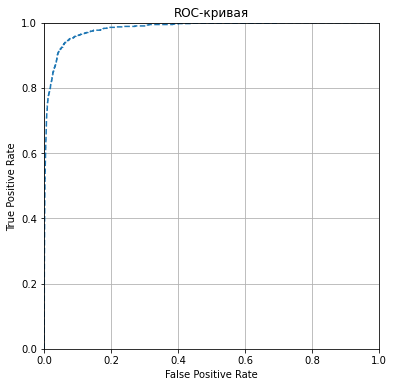

In [37]:
logit_valid_pred_proba2 = sgd_grid_searcher1.best_estimator_.predict_proba(X_valid_nf1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, logit_valid_pred_proba2)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.show()

### 8. Предсказание на тестовых данных

In [38]:
logit_test_pred_proba2 = sgd_grid_searcher1.best_estimator_.predict_proba(X_test_nf1)[:, 1]
write_to_submission_file(logit_test_pred_proba2, 'result.csv')
print('Team name: [YDF & MIPT] Шумов Артём Алексеевич')
print('Kaggle score: 0.94255')

Team name: [YDF & MIPT] Шумов Артём Алексеевич
Kaggle score: 0.94255
